# Description of the project

You work for a startup that sells food. You need to figure out how users of your mobile app behave.
Examine the sales funnel. Find out how users get to the purchase. How many users reach the purchase, and how many are "stuck" in the previous steps? Which ones exactly?
After that, examine the results of the A/A/B experiment. The designers wanted to change the fonts throughout the application, and the managers were afraid that it would be unusual for users. We agreed to make a decision based on the results of the A/A/B test. The users were divided into 3 groups: 2 control ones with old fonts and one experimental one with new ones. Find out which font is better.
Creating two A groups instead of one has certain advantages. If the two control groups turn out to be equal, you can be sure of the accuracy of the test. If there are significant differences between the values of A and A, this will help to identify the factors that led to the distortion of the results. Comparing the control groups also helps to understand how much time and data will be required for further tests.
In the case of general analytics and an A/A/B experiment, work with the same data. There are always experiments in real projects. Analysts examine the quality of the application based on general data, without taking into account whether users belong to experiments. 


## General information

In [1]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
from scipy import stats as st
from scipy.stats import norm
import numpy as np
import math as mth
import datetime
import statistics
datetime.datetime.strptime

<function datetime.strptime>

In [2]:
# Read file
df = pd.read_csv('logs_exp.csv', sep=',', index_col=0)

In [3]:
# Info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


In [4]:
# First 5 string
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [5]:
# Checking the number of empty entries
df.isna().sum()

EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64

In [6]:
# Checking the number of duplicates
df.duplicated().sum()

413

In [7]:
# Checking for duplicates
df[df.duplicated()]

,EventName,DeviceIDHash,EventTimestamp,ExpId
453,MainScreenAppear,5613408041324010552,1564474784,248
2350,CartScreenAppear,1694940645335807244,1564609899,248
3573,MainScreenAppear,434103746454591587,1564628377,248
4076,MainScreenAppear,3761373764179762633,1564631266,247
4803,MainScreenAppear,2835328739789306622,1564634641,248
...,...,...,...,...
242329,MainScreenAppear,8870358373313968633,1565206004,247
242332,PaymentScreenSuccessful,4718002964983105693,1565206005,247
242360,PaymentScreenSuccessful,2382591782303281935,1565206049,246
242362,CartScreenAppear,2382591782303281935,1565206049,246


In [8]:
# Remove duplicates from the dataset
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

I have data on users' visits to the mobile app for food purchases. A total of 244,126 observations were collected by columns eventName — the name of the event, DeviceIDHash — the unique identifier of the user's device, EventTimestamp — the time of the event, ExpId — the experiment number. There were no gaps in the data. There are also duplicates in dataset 413, given the date of the visit, such duplicates are unlikely. It is necessary to remove them, as there are a small number of them.

## Data preparation stage

### Change column names

In [9]:
# Change column names
df.columns = ['event_name', 'uid', 'event_datetime', 'exp_id']

### Adding a date and time column, as well as a separate date column

In [10]:
# Adding a date and time column, as well as a separate date column
df['event_datetime'] = pd.to_datetime(df['event_datetime'], unit='s', origin='unix')
df['event_datetime'] =  pd.to_datetime(df['event_datetime'], infer_datetime_format=True)

In [11]:
df['event_date'] = df['event_datetime'].dt.date

In [12]:
# First 5 string
df.head()

,event_name,uid,event_datetime,exp_id,event_date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


The date was converted from unix format to date and time format. A date column has also been added.

## Checking the data

In [13]:
number_of_logs = df.shape[0]
print('Total events in the log:', number_of_logs)

Total events in the log: 243713


In [14]:
number_of_users = df['uid'].nunique()
print('Total users in the log:', number_of_users)

Total users in the log: 7551


In [15]:
avg_event_per_user = number_of_logs / number_of_users
print('On average, the user has {:.2f} events.'.format(avg_event_per_user))

On average, the user has 32.28 events.


### Event distribution

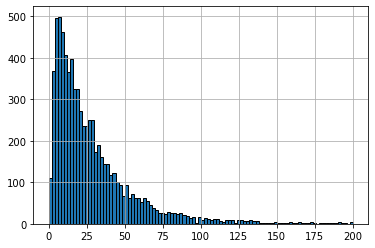

In [16]:
# Event distribution
df.groupby('uid')['exp_id'].count().hist(bins=100, range=(0,200), ec='black')
plt.show()

In my opinion, the average most accurately describes the distribution.

In [17]:
# The number of records for each user
events_per_users = df['uid'].value_counts()
events_per_users

6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
                       ... 
6888746892508752          1
6671109879025379318       1
1223708690315846789       1
5229230634268921313       1
2408195006658927235       1
Name: uid, Length: 7551, dtype: int64

There are 7551 unique users in the dataset. On average, each user performs 32 actions in this test. I assume that this indicator is normal, since before placing an order, the user usually browses pages with products, makes comparisons and various transitions from page to page.

In [18]:
# Min date
min_data = df['event_datetime'].min()
min_data

Timestamp('2019-07-25 04:43:36')

In [19]:
# Max date
max_data = df['event_datetime'].max()
max_data

Timestamp('2019-08-07 21:15:17')

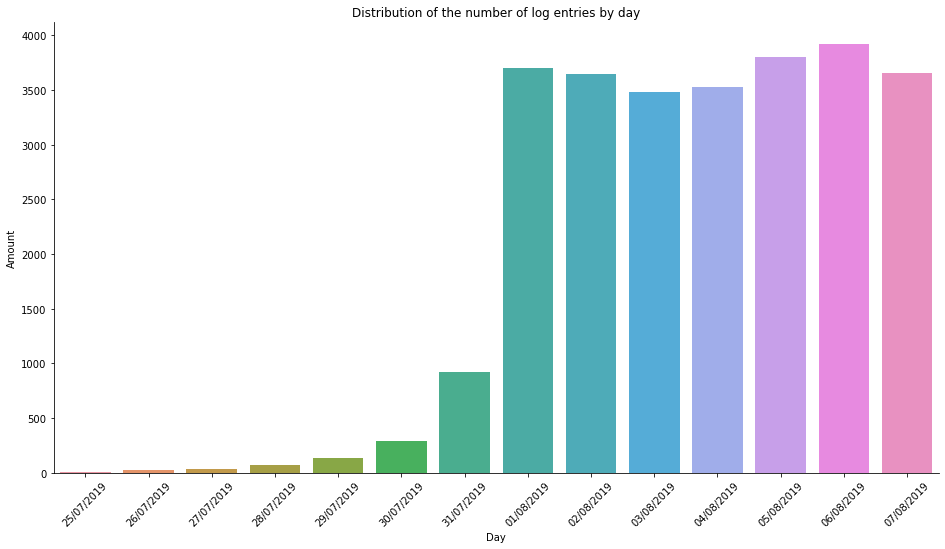

In [20]:
# Group them to understand how many users there were during the period
data_for_period = (df
                   .groupby('event_date')
                   .agg({'uid':'nunique'})
                   .sort_values(by='event_date')
                   .reset_index()
                  )
data_for_period = data_for_period.set_index('event_date')
data_for_period = data_for_period.asfreq('D')
data_for_period
 
 
ax = sns.catplot(y='uid', x= 'event_date', kind = 'bar', data=data_for_period.reset_index(), height=7, aspect=2)
(ax
 .set_xticklabels(rotation=45)
 .set_xticklabels(data_for_period.index.strftime("%d/%m/%Y"))
 .set(title = 'Distribution of the number of log entries by day')
 .set(xlabel = 'Day')
 .set(ylabel = 'Amount')
)
sns.despine()

The first login to the application was made on July 25, 2019, the last one was on August 07, 2019. It is obvious on the graph that before August 01 there was a small number of users who logged into the application. I think it would be more correct to filter after the date of August 01, 2019.

### Filtering data after August 01, 2019

In [21]:
# Filtering data after August 01, 2019
ts = pd.Timestamp
df_query = df.query('event_datetime >= @ts("20190801T000000")')
df_query

,event_name,uid,event_datetime,exp_id,event_date
2826,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2827,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2828,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2829,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2830,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01
...,...,...,...,...,...
243708,MainScreenAppear,4599628364049201812,2019-08-07 21:12:25,247,2019-08-07
243709,MainScreenAppear,5849806612437486590,2019-08-07 21:13:59,246,2019-08-07
243710,MainScreenAppear,5746969938801999050,2019-08-07 21:14:43,246,2019-08-07
243711,MainScreenAppear,5746969938801999050,2019-08-07 21:14:58,246,2019-08-07


We will delete the older data before August 1, 2019, as the graph shows that test users did not often log into the application, which indicates that testing began on August 1. It is possible that admins or admins under their test users visited before August 1. Therefore, it does not make sense to take this data.

In [22]:
print('The data has been reduced by {} lines.'.format(df.shape[0] - df_query.shape[0]))

The data has been reduced by 2826 lines.


In [23]:
number_of_users_df_query = df_query['uid'].nunique()
print('Total users in the log of the abbreviated dataset:', number_of_users)
print('The data has decreased by {} unique users.'.format(number_of_users - number_of_users_df_query))

Total users in the log of the abbreviated dataset: 7551
The data has decreased by 17 unique users.


In [24]:
print('The data was reduced by {:.2%} of rows.'.format((df.shape[0] - df_query.shape[0]) / df.shape[0]))

The data was reduced by 1.16% of rows.


In [25]:
### Checking that I have users from all three experimental groups.
group_exp_id = (df_query
    .groupby('exp_id')
    .agg({'uid':'nunique'})
    .sort_values(by='uid')
    .reset_index())
group_exp_id

,exp_id,uid
0,246,2484
1,247,2513
2,248,2537


The data are available in all 3 experimental groups. There are 248 users in the group the most, which may slightly worsen the results of the experiment.

## Event funnel

In [26]:
# Events in logs. Frequency of logs
df_query['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Most often, users go to the main screen of the application. The page with answers to questions, FAQ or reviews about the application is accessed only 1005 times.

### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.

In [27]:
# The number of users per action
number_event = df_query.groupby('event_name').agg({'uid':'nunique'}).sort_values(by='uid', ascending=False).reset_index()
number_event

,event_name,uid
0,MainScreenAppear,7419
1,OffersScreenAppear,4593
2,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [28]:
# The number of users per action and its percentage
number_event['ratio'] = round(number_event['uid'] / df_query['uid'].nunique(), 3)
number_event

,event_name,uid,ratio
0,MainScreenAppear,7419,0.985
1,OffersScreenAppear,4593,0.610
2,CartScreenAppear,3734,0.496
3,PaymentScreenSuccessful,3539,0.470
4,Tutorial,840,0.111


7,419 unique users go to the main page, which corresponds to 98.5%. It is worth noting that 3,734 users go to the checkout page, and 3,539 users go to the successful payment page. It is worth paying attention to the developers, perhaps this is due to errors when placing an order.

It can be assumed that users go to the main page of the mobile application first. Next, they go to the product selection page, then go to the shopping cart, after that users go to the payment screen. The Tutorial item may mean some reviews, FAQ, or something about evaluating the service. This item can be removed from the analysis, since this screen can be accessed from different pages of the application.

In [29]:
number_event = number_event.drop(index=[4])
number_event

,event_name,uid,ratio
0,MainScreenAppear,7419,0.985
1,OffersScreenAppear,4593,0.610
2,CartScreenAppear,3734,0.496
3,PaymentScreenSuccessful,3539,0.470


In [30]:
### Calculation of the number of users without taking into account the sequence of transitions
fig = go.Figure(go.Funnel(
    y = number_event['event_name'],
    x = number_event['uid'],  textposition = "inside",
    textinfo = "value+percent initial+percent total+percent previous", marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal" ]}))
fig.show()

If we take into account the calculation without taking into account the sequence of user transitions from stage to stage, then 62% of users switch to the product selection screen - this is an average indicator that can be improved. It is possible that users intuitively do not understand where to go to the product catalog. After that, 81% of users go to the shopping cart screen, which corresponds to 50% of the initial number of users. 95% of those who go to the shopping cart complete the operation before paying for goods, which corresponds to 48% of the total number of users.

In [31]:
### Calculation of the number of users, taking into account the sequence of transitions
users = df.pivot_table(
    index='uid', 
    columns='event_name', 
    values='event_datetime',
    aggfunc='min')

step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

n_mainscreen = users[step_1].shape[0]
n_offers = users[step_2].shape[0]
n_cart = users[step_3].shape[0]
n_payment = users[step_4].shape[0]

print('Mainscreen Visitors:', n_mainscreen)
print('Offers Visitors:', n_offers)
print('Cart Visitors:', n_cart)
print('Payment Visitors:', n_payment)

Mainscreen Visitors: 7439
Offers Visitors: 4067
Cart Visitors: 1611
Payment Visitors: 448


In [32]:
d = {'event_name': ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear', 'PaymentScreenSuccessful'], 
     'uid': [n_mainscreen, n_offers, n_cart, n_payment]}
number_event1 = pd.DataFrame(data=d)
number_event1

,event_name,uid
0,MainScreenAppear,7439
1,OffersScreenAppear,4067
2,CartScreenAppear,1611
3,PaymentScreenSuccessful,448


In [33]:
fig = go.Figure(go.Funnel(
    y = number_event1['event_name'],
    x = number_event1['uid'],  textposition = "auto",
    textinfo = "value+percent initial+percent total+percent previous",
    marker = {"color": ["deepskyblue", "lightsalmon", "tan", "teal" ]}))
fig.show()

## Summary

If we take into account the sequence of user transitions from stage to stage, then 55% of users go to the product selection screen. After that, 40% of users go to the shopping cart screen, which corresponds to 22% of the initial number of users. 28% of those who go to the shopping cart bring the operation to the payment of goods, which corresponds to 6% of the total number of users.

Without taking into account the sequence of transition from stage to stage, about 38% of users are lost. Taking into account the sequence of transition from stage to stage, about 45% of users are lost.

We calculated the sales funnel without taking into account which page is clicked on. That is, in my opinion, users can go from the main screen directly to the shopping cart if they have already added an item to the cart. 
We also made a crow taking into account the sequence "Home page", "Offer page", "Go to cart", "Successful payment screen". Different approaches lose different numbers of users.

Without taking into account the sequence of transition from stage to stage, about 48% of users reach payment. Taking into account the sequence of transition from stage to stage, about 6% of users reach payment.

## The results of the experiment

In [34]:
# The number of users in each experimental group
group_exp_id

,exp_id,uid
0,246,2484
1,247,2513
2,248,2537


There are 2484 users in group 246. There are 2,513 users in group 247. There are 2,537 users in group 248.

### Experiment 

We have 2 control groups for the A/A experiment to check the correctness of all mechanisms and calculations. Let's check if the statistical criteria find the difference between samples 246 and 247.

Let's put forward hypotheses: </br>
H0: the shares of two samples of two general populations are equal </br>
H1: the proportions of the two samples of the two general populations differ </br>

In [35]:
event_list = ['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear', 'PaymentScreenSuccessful']
 
def z_test(data1, data2, event):
    
    alpha = 0.05 # critical level of statistical significance
    
    # total users in group 1 and group 2
    n_users = np.array([data1['uid'].nunique(), data2['uid'].nunique()]) 
        
    # users who have committed an event to Group 1 and group 2
    successes = np.array([data1[data1['event_name'] == event]['uid'].nunique(), 
                          data2[data2['event_name'] == event]['uid'].nunique()])
    
    # the proportion of success in the first group:
    p1 = successes[0]/n_users[0]
 
    # the proportion of success in the second group:
    p2 = successes[1]/n_users[1]
 
    # the proportion of success in the combined dataset:
    p_combined = (successes[0] + successes[1]) / (n_users[0] + n_users[1])
 
    # the difference in proportions in datasets
    difference = p1 - p2 
    
    # statistics in standard deviations of the standard normal distribution
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))
 
    # we set the standard normal distribution (mean 0, standard deviation 1)
    distr = st.norm(0, 1)  
    
    # statistics in standard deviations of the standard normal distribution
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / n_users[0] + 1 / n_users[1])
    )
 
    # we set the standard normal distribution (mean 0, standard deviation 1)
    distr = st.norm(0, 1)
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-value по {}: {}'.format(event, p_value))
 
    if p_value < alpha:
        print('We reject the null hypothesis: there is a significant difference between the shares')
    else:
        print('It was not possible to reject the null hypothesis, there is no reason to consider the shares different')

### Statistical criteria for the difference between samples 246 and 247.

In [36]:
for event in event_list:
    z_test(df_query[df_query['exp_id'] == 246], df_query[df_query['exp_id'] == 247], event)

p-value по CartScreenAppear: 0.22883372237997213
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
p-value по MainScreenAppear: 0.7570597232046099
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
p-value по OffersScreenAppear: 0.2480954578522181
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
p-value по PaymentScreenSuccessful: 0.11456679313141849
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


There are no differences in the proportions of parameters between groups 246 and 247. All p-values are greater than 5%, and even more than 10%, so we can assume that these groups are identical, respectively, we can continue the experiment further.

In [37]:
# I choose the most popular event in each group
g246 = df_query[df_query['exp_id'] == 246]
g247 = df_query[df_query['exp_id'] == 247]
g248 = df_query[df_query['exp_id'] == 248]

g246_grouped = g246.groupby(['exp_id', 'event_name']).agg({'uid':'nunique'}).sort_values(by='uid', ascending=False).reset_index().drop(index=[4])
g247_grouped = g247.groupby(['exp_id', 'event_name']).agg({'uid':'nunique'}).sort_values(by='uid', ascending=False).reset_index().drop(index=[4])
g248_grouped = g248.groupby(['exp_id', 'event_name']).agg({'uid':'nunique'}).sort_values(by='uid', ascending=False).reset_index().drop(index=[4])

In [38]:
g246_grouped['ratio'] = g246_grouped['uid'] / g246_grouped['uid'].sum()
g246_grouped

,exp_id,event_name,uid,ratio
0,246,MainScreenAppear,2450,0.379374
1,246,OffersScreenAppear,1542,0.238774
2,246,CartScreenAppear,1266,0.196036
3,246,PaymentScreenSuccessful,1200,0.185816


In [39]:
g247_grouped['ratio'] = g247_grouped['uid'] / g247_grouped['uid'].sum()
g247_grouped

,exp_id,event_name,uid,ratio
0,247,MainScreenAppear,2476,0.387359
1,247,OffersScreenAppear,1520,0.237797
2,247,CartScreenAppear,1238,0.193680
3,247,PaymentScreenSuccessful,1158,0.181164


In [40]:
g248_grouped['ratio'] = g248_grouped['uid'] / g248_grouped['uid'].sum()
g248_grouped

,exp_id,event_name,uid,ratio
0,248,MainScreenAppear,2493,0.387413
1,248,OffersScreenAppear,1531,0.237918
2,248,CartScreenAppear,1230,0.191142
3,248,PaymentScreenSuccessful,1181,0.183528


### Statistical criteria for the difference between samples 246 and 248.

In [41]:
for event in event_list:
    z_test(df_query[df_query['exp_id'] == 246], df_query[df_query['exp_id'] == 248], event)

p-value по CartScreenAppear: 0.07842923237520116
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
p-value по MainScreenAppear: 0.2949721933554552
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
p-value по OffersScreenAppear: 0.20836205402738917
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
p-value по PaymentScreenSuccessful: 0.2122553275697796
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


There are no differences in the proportions of parameters between groups 246 and 248. All p-values are greater than 5%, however, for the CartScreenAppear parameter the value is less than 10%, so we can assume that these groups are identical, respectively, we can continue the experiment further. It is worth noting that for the CartScreenAppear parameter, it may be logical to apply changes to the font at a significance level of 10%.

### Statistical criteria for the difference between samples 247 and 248.

In [42]:
for event in event_list:
    z_test(df_query[df_query['exp_id'] == 247], df_query[df_query['exp_id'] == 248], event)

p-value по CartScreenAppear: 0.5786197879539783
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
p-value по MainScreenAppear: 0.4587053616621515
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
p-value по OffersScreenAppear: 0.9197817830592261
It was not possible to reject the null hypothesis, there is no reason to consider the shares different
p-value по PaymentScreenSuccessful: 0.7373415053803964
It was not possible to reject the null hypothesis, there is no reason to consider the shares different


There are no differences in the proportions of parameters between groups 247 and 248. All p-values are greater than 5%, and even more than 10%, so we can assume that these groups are identical, respectively, we can continue the experiment further.

### Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?

In [43]:
def z_test (n1, x1, n2, x2, alpha):
    p1 = x1 / n1
    p2 = x2 / n2 
    p = (p1 * n1 + p2 * n2) / (n1 + n2)
    SE = np.sqrt(p * (1 - p) * (1 / n1 + 1 / n2))
    m = SE * norm.ppf(1 - alpha/2)
    z_stat = (p1 - p2) / SE
    p = norm.cdf(np.abs(z_stat))
    return 2 * (1 - p)

In [44]:
# I consider 246 and 247 to be equal
events = df_query.copy()
events['exp_id'] = events['exp_id'].astype(str).str.replace('246|247', 'A').str.replace('248', 'B')
# number of unique users
totals = events.groupby('exp_id').agg({'uid':'nunique'})['uid']
display(totals)
counts = events.pivot_table(index='event_name', columns='exp_id', values='uid', aggfunc='nunique')
# correction of the significance level (according to 5 hypotheses in the AA and AB test)
counts['alpha'] = 0.05 / (17)
counts['p-value'] = counts.apply(lambda x: z_test(totals['A'], x['A'], totals['B'], x['B'], counts['alpha']), axis=1)
counts

C:\Users\chern\AppData\Local\Temp\ipykernel_15108\1770414464.py:3: FutureWarning:

The default value of regex will change from True to False in a future version.



exp_id
A    4997
B    2537
Name: uid, dtype: int64

exp_id,A,B,alpha,p-value
event_name,,,,
CartScreenAppear,2504,1230,0.002941,0.181759
MainScreenAppear,4926,2493,0.002941,0.294245
OffersScreenAppear,3062,1531,0.002941,0.434255
PaymentScreenSuccessful,2358,1181,0.002941,0.600429
Tutorial,561,279,0.002941,0.764862


We chose 0.05 as the significance criterion. Due to Bonferroni's correction for multiple checks, the adjusted significance criterion is 0.05 / 17 = 0.00294. At the same time, none of the pairwise checks gave a p-value below even the uncorrected significance level of 0.05, i.e. it was not possible to reject any null hypothesis.

We made 17 checks of statistical hypotheses, 12 checks between groups 248, 247 and 246 in pairs without taking into account the Tutorial check. When checking the 246+247 and 248 groups, 5 parameters were checked. For our experiment, it makes no sense to change the significance criterion, since all p-value values for all hypothesis tests are much higher than 0.1.

# General conclusion

Based on the results of the analysis, it can be concluded that the font changes will not bring any dividends. This will not affect users at all. The difference between fonts will not be noticed by users. Managers should make decisions that fonts should not be changed.